In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
count=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count == 5:
            break
    if count == 5:  # ensure we stop outer loop too
        break
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/1e5ba644-efeb-4bd3-b878-a0606cf8a992___RS_Late.B 6272_flipLR.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late.B 5324.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/532b2c20-d17b-4b3e-a69e-54a6e5343014___GHLB2 Leaf 9004.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/418ae33c-5f61-4531-82df-8608d82a7a90___RS_Late.B 5574.JPG
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/7f4621fe-72ce-4f4c-a20e-320250ec8a9d___R

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

2025-06-28 17:03:56.730387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751130236.936222      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751130236.992753      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TRAIN_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VAL_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

# Normalize images
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
    
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
).map(preprocess).repeat().prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
).map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 70295 files belonging to 38 classes.


I0000 00:00:1751130289.300732      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 17572 files belonging to 38 classes.


In [4]:
def se_block(inputs, se_ratio=0.25):
    filters = inputs.shape[-1]
    se_filters = max(1, int(filters * se_ratio))
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(se_filters, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([inputs, se])


In [5]:
def cbam_block(inputs, reduction_ratio=16):
    # Channel Attention
    channel_avg = layers.GlobalAveragePooling2D()(inputs)
    channel_max = layers.GlobalMaxPooling2D()(inputs)
    
    shared_dense = tf.keras.Sequential([
        layers.Dense(inputs.shape[-1] // reduction_ratio, activation='relu'),
        layers.Dense(inputs.shape[-1])
    ])

    avg_out = shared_dense(channel_avg)
    max_out = shared_dense(channel_max)

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, inputs.shape[-1]))(channel_attention)
    x = layers.Multiply()([inputs, channel_attention])

    # Spatial Attention using only Keras layers
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x

In [6]:
def mbconv_block(inputs, out_channels, expansion_factor, kernel_size, strides, se_ratio=0.25):
    in_channels = inputs.shape[-1]
    x = inputs

    # Expansion phase
    if expansion_factor != 1:
        x = layers.Conv2D(in_channels * expansion_factor, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)

    # Depthwise conv
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Squeeze-and-Excitation
    x = se_block(x, se_ratio=se_ratio)

    # Projection phase
    x = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if strides == 1 and in_channels == out_channels:
        x = layers.Add()([inputs, x])
    
    return x

In [7]:
def EfficientNetB0_custom(input_shape=(224,224, 3), num_classes=38, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # MBConv blocks (adapted from official B4 config)
    # (repeats, out_channels, kernel_size, strides)
    x = mbconv_block(x,out_channels=16,expansion_factor=1,kernel_size=3,strides=1)
    block_configs = [
        (2, 24, 3, 2),
        (2, 40, 5, 2),
        (3, 80, 3, 2),
        (3, 112, 5, 1),
        (4, 192, 5, 2),
        (1, 320, 3, 1),
    ]

    expansion_factor = 6
    for repeats, out_channels, kernel_size, strides in block_configs:
        for i in range(repeats):
            x = mbconv_block(
                x,
                out_channels=out_channels,
                expansion_factor=expansion_factor,
                kernel_size=kernel_size,
                strides=strides if i == 0 else 1
            )

    # Head
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = cbam_block(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [8]:
model_sample = EfficientNetB0_custom()
model_sample.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 112, 112, 32)   │            288 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1, 1, 8)        │            264 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 1, 1, 32)       │            288 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 112, 112, 32)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 16)   │            512 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 96)   │          1,536 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 96)   │            384 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,439,801 (28.38 MB)

 Trainable params: 7,397,785 (28.22 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [9]:
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Image settings
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
NUM_CLASSES = 38
NUM_TRAIN_IMAGES = 70295
NUM_VAL_IMAGES = 17572
steps_per_epoch = math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
validation_steps = math.ceil(NUM_VAL_IMAGES / BATCH_SIZE)

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "efficientnet_b0_new_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

log_dir = "logs/efficientnet_b4"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_accuracy"
)

csv_logger = CSVLogger("training_log.csv", append=True)

In [10]:
from tensorflow.keras.models import load_model
model=EfficientNetB0_custom()

In [11]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
EPOCHS = 30  
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cb, csv_logger]
)

Epoch 1/30


I0000 00:00:1751130347.359817      64 service.cc:148] XLA service 0x783928002dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751130347.360353      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751130352.301687      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751130359.872233      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130360.060913      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130360.528229      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130360.7342

2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3959 - loss: 2.0270

E0000 00:00:1751130623.908186      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130624.094742      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130624.543125      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130624.751674      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751130625.113103      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3960 - loss: 2.0266
Epoch 1: val_accuracy improved from -inf to 0.85374, saving model to efficientnet_b0_new_model.h5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 381s 136ms/step - accuracy: 0.3961 - loss: 2.0263 - val_accuracy: 0.8537 - val_loss: 0.4447
Epoch 2/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8710 - loss: 0.3961
Epoch 2: val_accuracy did not improve from 0.85374
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 253s 115ms/step - accuracy: 0.8710 - loss: 0.3961 - val_accuracy: 0.8165 - val_loss: 0.6182
Epoch 3/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9297 - loss: 0.2169
Epoch 3: val_accuracy improved from 0.85374 to 0.90860, saving model to efficientnet_b0_new_model.h5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 254s 116ms/step - accuracy: 0.9297 - loss: 0.2169 - val_accuracy: 0.9086 - val_loss: 0.2918
Epoch 4/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9521 - loss: 0.1442
Epoch 4: val_accuracy did not im

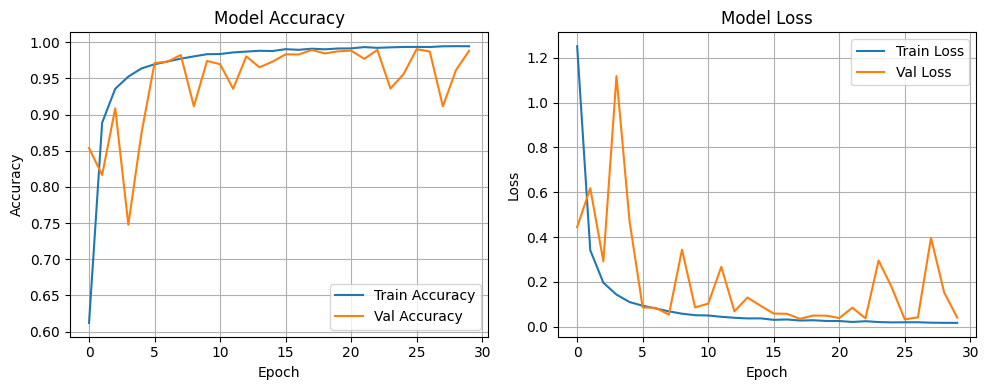

In [13]:
# Save accuracy and loss plots
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_plot.png")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")

plt.tight_layout()
plt.show()